In [1]:
!pip install pyspark

In [2]:
try:
    from pyspark.sql import SparkSession
    from pyspark import SparkContext, SparkConf
    
    # SparkMLibs
    from pyspark.ml.feature import PCA
    from pyspark.ml.linalg import Vectors
    from pyspark.ml.feature import VectorAssembler
except ImportError as e:
    raise ImportError('PySpark is not Configured')
    
# Creating a Spark-Context
sc = SparkContext.getOrCreate(SparkConf().setMaster('local[*]'))
# Spark Builder
spark = SparkSession.builder.getOrCreate()

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [3]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-05-31 18:15:05--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-05-31 18:15:05--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-05-31 18:15:05--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

In [4]:
df = spark.read.parquet('washing.parquet')
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [7]:
WindowData = spark.sql("""
SELECT * from (
    SELECT
    min(temperature) over w as min_temperature,
    max(temperature) over w as max_temperature, 
    min(voltage) over w as min_voltage,
    max(voltage) over w as max_voltage,
    min(flowrate) over w as min_flowrate,
    max(flowrate) over w as max_flowrate,
    min(frequency) over w as min_frequency,
    max(frequency) over w as max_frequency,
    min(hardness) over w as min_hardness,
    max(hardness) over w as max_hardness,
    min(speed) over w as min_speed,
    max(speed) over w as max_speed
    FROM washing 
    WINDOW w AS (ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING) 
)
WHERE min_temperature is not null 
AND max_temperature is not null
AND min_voltage is not null
AND max_voltage is not null
AND min_flowrate is not null
AND max_flowrate is not null
AND min_frequency is not null
AND max_frequency is not null
AND min_hardness is not null
AND min_speed is not null
AND max_speed is not null   
""")

In [8]:
df.count() - WindowData.count() # No. of Rows that were Deleted

7

In [15]:
assembler = VectorAssembler(inputCols = WindowData.columns, outputCol = "features")
features  = assembler.transform(WindowData)

In [16]:
features.rdd.map(lambda r : r.features).take(10)

[DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 71.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 80.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 72.0, 80.0, 1033.0, 1046.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0])]

In [17]:
%%time
PCAModel = PCA(k = 3, inputCol = "features", outputCol = "PCAFeatures").fit(features)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 2.3 s


In [20]:
PCAResult = PCAModel.transform(features).select("PCAFeatures")

In [21]:
PCAResult.show(truncate = False)

+-----------------------------------------------------------+
|PCAFeatures                                                |
+-----------------------------------------------------------+
|[1459.9789705814187,-18.745237781780922,70.78430794796873] |
|[1459.995481828676,-19.11343146165273,70.72738871425986]   |
|[1460.0895843561282,-20.969471062922928,70.75630600322052] |
|[1469.6993929419532,-20.403124647615513,62.013569674880955]|
|[1469.7159041892107,-20.771318327487293,61.95665044117209] |
|[1469.7128317338704,-20.790751117222456,61.896106678330966]|
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1483.5412027684088,-20.006222577501354,66.82710394284209] |
|[1483.5171090223353,-20.867020421583753,66.86707301954084] |
|[1483.4224268542928,-19.87574823665505,66.93027077913985]  |
|[1483.4

In [22]:
PCAResult.count()

2051

In [23]:
RDD = PCAResult.rdd.sample(False, 0.8)

In [24]:
RDD.take(5)

[Row(PCAFeatures=DenseVector([1459.979, -18.7452, 70.7843])),
 Row(PCAFeatures=DenseVector([1459.9955, -19.1134, 70.7274])),
 Row(PCAFeatures=DenseVector([1469.7128, -20.7908, 61.8961])),
 Row(PCAFeatures=DenseVector([1478.353, -20.2946, 71.6755])),
 Row(PCAFeatures=DenseVector([1478.353, -20.2946, 71.6755]))]

In [27]:
x = RDD.map(lambda x: x.PCAFeatures).map(lambda x: x[0]).collect()
y = RDD.map(lambda x: x.PCAFeatures).map(lambda x: x[1]).collect()
z = RDD.map(lambda x: x.PCAFeatures).map(lambda x: x[2]).collect()

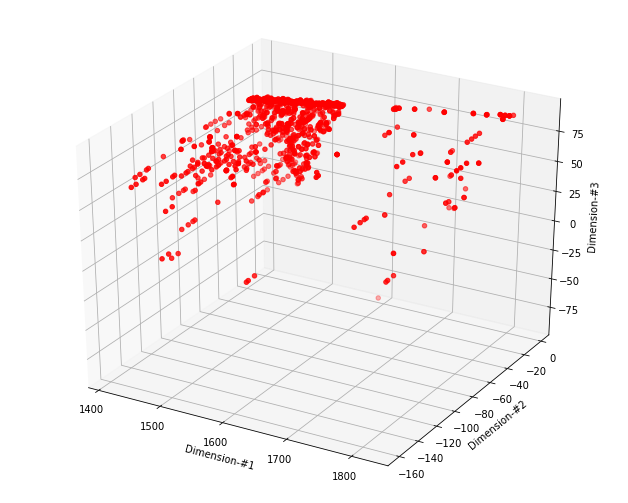

In [36]:
fig = plt.figure(figsize = (11, 9))
axs = fig.add_subplot(111, projection = '3d')

axs.scatter(x, y, z, c = 'r', marker = 'o')

axs.set_xlabel('Dimension-#1')
axs.set_ylabel('Dimension-#2')
axs.set_zlabel('Dimension-#3')

plt.show()